In [1]:
import numpy as np
from tensorflow.keras import Model as Model_
from tensorflow.keras.layers import Input, ReLU, LSTM, Dense, TimeDistributed, Bidirectional, Normalization, GaussianNoise 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd

print(tf.keras.__version__)

2.8.0


In [2]:
#Need only to be used with google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install tensorflow_model_remediation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 142 kB 14.8 MB/s 


In [4]:
import tensorflow_model_remediation.min_diff.losses.mmd_loss as MMD
import tensorflow_model_remediation.min_diff.losses.adjusted_mmd_loss as adjustedMMD

In [5]:
import os
import re

class Dataset_Preprocessing:
    def __init__(self, dir_path, include_dimension = 2, sample_size = 50, total_classes = 17, datatype = 'float32'):
        
        #Dataset Directory path
        self.dir_path = dir_path
        
        #Which Dimension file to include, possible values: 2 and 3
        self.include_dimension = include_dimension
        
        #Total frames in one Sample
        self.sample_size = sample_size
        
        #Default Datatype for all the samples
        self.datatype = datatype
        
        #Activity classes to include
        self.classes = ['SittingDown', 'Walking', 'Directions', 'Discussion', 'Sitting', 'Phoning', 'Eating', 'Posing', 'Greeting', 'Smoking']
        
        #Total activity classes
        self.total_classes = len(self.classes)
        
        #Subject Folders names in the Dataset
        self.internal_folders = ['S1', 'S5','S6','S7','S8','S9','S11']
    
    def read_dataset(self):
        try:
            #Contains all the different activity vectors
            activity_vector = {}
            
            #Contains the overall dataset
            sampled_data = None
            
            #Based on dimensions, which folder to use for extracting the dataset files
            data_folder = 'Poses_D2_Positions' if self.include_dimension == 2 else 'Poses_D3_Positions'
            
            #Checking if the dataset path is valid
            if not os.path.exists(self.dir_path):
                print('The Data Directory Does not Exist!')
                return None

            #Iterating over all the subject folders
            for fld in self.internal_folders:
                #Iterating for each file in the specified folder
                for file in os.listdir(os.path.join(self.dir_path, fld, data_folder)):
                    #Extracting the activity from the filename
                    activity = self.__extract_activity(file)
                    
                    if activity not in self.classes:
                        continue
                    
                    #Reading the CSV file using Pandas
                    data = pd.read_csv(os.path.join(self.dir_path, fld, data_folder, file), header=None)

                    #Formulating the activity vector using one hot encoding
                    if activity not in activity_vector:
                        total_keys = len(activity_vector.keys())
                        activity_vector[activity] = np.zeros(self.total_classes)
                        activity_vector[activity][total_keys] = 1
                    vector = activity_vector[activity]
                    
                    #Sampling the dataset
                    grouped_sample = self.__group_samples(data, self.sample_size, vector)
                    sampled_data = grouped_sample if sampled_data is None else np.append(sampled_data, grouped_sample, axis=0)
            
            #Changing the Datatype
            sampled_data = sampled_data.astype(self.datatype)
            
            return sampled_data
        except Exception as e:
            print(e)
    
    def __extract_activity(self, filename):
        try:
            #Extracting the filename and excluding the extension
            name = os.path.splitext(filename)[0]
            
            #Substituting the empty string with characters other than english alphabets
            activity = re.sub('[^A-Za-z]+' , '' , name)
            return activity
        except Exception as e:
            print(e)
    
    def __group_samples(self, dataset, sample_size, activity):
        try:
            #Checking if the dataset is a Pandas Dataframe
            if not isinstance(dataset, pd.DataFrame):
                print('Expecting Pandas Dataframe, but got {}'.format(type(dataset)))
                return None
            
            #Appending activity class to each row in the dataset
            dataset = pd.concat([dataset, pd.DataFrame(np.tile(activity, (dataset.shape[0],1)))], axis=1)
            
            #Reshaping the dataset into sample batches
            total_samples = dataset.shape[0]//sample_size
            total_features = dataset.shape[1]
            grouped_rows = dataset.to_numpy()[:total_samples*self.sample_size].reshape((-1,self.sample_size, total_features))
            
            return grouped_rows
        except Exception as e:
            print(e)

In [6]:
#For long term prediction, we need a sample size of 60(10 frames input sequance, 50 frames predicted sequance)
sampled_data = Dataset_Preprocessing('/content/drive/MyDrive/Colab Notebooks/H3.6csv', sample_size=60).read_dataset()

##Splitting dataset to features and labels

In [7]:
def split_to_features_labels(dataset, input_sequance_size=10) :
    """
    Function for splitting the data into features(with sequance size=iput_sequance_size)
    and labels which should be the remainder of the sample length 
    """
    assert input_sequance_size < dataset.shape[1], f"input sequance should be smaller than the total sample size"
    features = dataset[:, np.s_[0:input_sequance_size], :]
    labels = dataset[:,np.s_[input_sequance_size:], :64]
    
    return features, labels

In [9]:
#To make the data divisible for batch size of 20
total_batches = sampled_data.shape[0]
sampled_data = sampled_data[:total_batches-(total_batches%20)]

In [10]:
sampled_dataX, sampled_dataY = split_to_features_labels(sampled_data, input_sequance_size=10)

In [11]:
print('Total Samples: {}'.format(sampled_dataY.shape[0]))
print('Total Frames: {}'.format(sampled_dataY.shape[1]))
print('Total Features: {}'.format(sampled_dataY.shape[2]))

Total Samples: 25520
Total Frames: 50
Total Features: 64


##Adding Preprocessing steps to improve model performance and robustness

In [13]:
#Downsampling to be implemented
def preprocess_data(sampled_dataX, sampled_dataY, normalize=True, add_noise=True
                    , downsample= False , stddev=0.05) :
    """
    Function to preprocess data by normalizing input features and adding guassian
    noise to increase model robustness
    """  
    if normalize :
      sampled_dataX =  tf.keras.utils.normalize(sampled_dataX, axis=2)
    if add_noise :
      guassian_noise_layer = tf.keras.layers.GaussianNoise(stddev=stddev)
      sampled_dataX = guassian_noise_layer(sampled_dataX)
    return sampled_dataX, sampled_dataY

In [14]:
preprocessed_sampled_dataX, preprocessed_sampled_dataY = preprocess_data(sampled_dataX, sampled_dataY) 

In [15]:
preprocessed_sampled_dataY.shape == sampled_dataY.shape

True

##Defining different components of the model

In [16]:
class InterpolationLayer(tf.keras.layers.Layer):
    """
    Custom interpolation layer extending the keras layer class
    it has one attribute num_frames to be interpolated between each two consecutive 
    timesteps
    it has one main function interpolateFrames  
    """
  
    def __init__(self, num_frames=5):
        super(InterpolationLayer, self).__init__()
        self.num_frames = num_frames
       
    def interpolateFrames(self, inputs):
      """
      Takes input tensors of shape(batch_size, timesteps, features)
      returns interpolated frames with shape(batch_size, timesteps*num_frames, features)
      """
      batch_size = inputs.shape[0]
      timesteps = inputs.shape[1]
      features = inputs.shape[2]
      interpolated_frames = tf.zeros([0, features])

      for batch in range(batch_size) :
        for t in range(timesteps) :
          for j in range(self.num_frames) :
            X_i0 = inputs[batch, t]
            if(t == timesteps-1) :
              X_i1 = inputs[batch, t]
            else :  
              X_i1 = inputs[batch, t+1]
            alpha_j = j/self.num_frames
            current_frame = alpha_j*X_i0 + (1-alpha_j)*X_i1
            current_frame = tf.reshape(current_frame, [1, features])
            interpolated_frames = tf.concat((interpolated_frames, current_frame), axis=0)
            
      interpolated_frames = tf.reshape(interpolated_frames,
                                       [batch_size, (timesteps)*self.num_frames, features])
      return interpolated_frames

    def call(self, inputs):
      return self.interpolateFrames(inputs)

In [46]:
class GlocalNet(Model_):
    """
    A full GlocalNet implementation include the three main stages
    Glogen generating initial sparse frames
    Interpolation layer generating dense frames from Glogen output
    Locgen generating the final output by smoothing the interpolated frames
    """
    def __init__(self, enocder_hidden_state=200, decoder_hidden_state=200, 
                 output_diminsion=64, LSTM_dropout=0.25, dense_activation='relu',
                 interpolation_frames=5, exclude_locgen=False):
        super(GlocalNet, self).__init__()
        self.exclude_locgen = exclude_locgen
        #Glogen layers
        self.glogen_encoder = LSTM(enocder_hidden_state, return_state=True
                                   , return_sequences=True, dropout=LSTM_dropout)
        self.glogen_decoder = LSTM(decoder_hidden_state, return_sequences=True,
                                   return_state=True, dropout=LSTM_dropout)
        #Locgen layers
        self.locgen_encoder = LSTM(enocder_hidden_state, return_sequences=True,
                                   return_state=True, dropout=LSTM_dropout)
        self.locgen_decoder = LSTM(decoder_hidden_state, return_sequences=True,
                                   return_state=True, dropout=LSTM_dropout)
        #Glogen dense layer
        self.glogen_dense_layer = TimeDistributed(Dense(output_diminsion,
                                                        activation=dense_activation)) 
        #Interpolation layer
        self.interpolation_layer = InterpolationLayer(num_frames=interpolation_frames)
        #Locgen dense layer
        self.locgen_dense_layer = TimeDistributed(Dense(output_diminsion,
                                                        activation=dense_activation)) 
        
    def call(self, inputs):
        #Glogen calls      
        encoder_outputs, state_h, state_c = self.glogen_encoder(inputs)
        encoder_states = [state_h, state_c]
        output, _, _ = self.glogen_decoder(encoder_outputs, initial_state=encoder_states)
        glogen_output = self.glogen_dense_layer(output)

        #Interpolation call
        interpolated_frames = self.interpolation_layer(glogen_output)
        
        if self.exclude_locgen :
          return interpolated_frames

        #Locgen calls
        locgen_encoder_outputs, locgen_state_h, locgen_state_c = self.locgen_encoder(interpolated_frames)
        locgen_encoder_states = [locgen_state_h, locgen_state_c]
        locgen_output, _, _ = self.locgen_decoder(locgen_encoder_outputs, initial_state=locgen_encoder_states)
        final_output = self.locgen_dense_layer(locgen_output)
        return final_output

In [18]:
class JointLoss() :
    """
    Joint loss class with two weight attributes for two different losses
    first one is the loss joint and the second is the loss_motion_flow
    """
    def __init__(self, lambda1=0.5, lambda2=0.5, mmd_kernel='gaussian') :
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.mmd_kernel = mmd_kernel

    def loss_joint(self, predicted_sequance_batch, target_sequance_batch) :
        """
        Loss between the joint positions and its corresponding counterparts in the groundtruth
        """
        diff_norm_2 = tf.math.reduce_sum(tf.square(tf.subtract(predicted_sequance_batch, target_sequance_batch)), axis=2)
        return tf.reduce_sum(diff_norm_2, axis=1) 

    def loss_motion_flow(self, predicted_sequance_batch, target_sequance_batch) :
        """
        Loss between the motion flow of predicted sequance and the ground truth
        where the motion flow is the euclidean distance between each two consecutive frames
        """
        predictions_tomporal_diffs = tf.experimental.numpy.diff(predicted_sequance_batch, axis=1)
        real_tomporal_diffs = tf.experimental.numpy.diff(target_sequance_batch, axis=1)
        prediction_motion_flow_diff_norm_2 = tf.reduce_sum(tf.square(tf.subtract(predictions_tomporal_diffs, real_tomporal_diffs)), axis=2)
        return tf.reduce_sum(prediction_motion_flow_diff_norm_2, axis=1)


    def total_loss(self, target_sequance_batch, predicted_sequance_batch) :
        """
        calculating the total loss through a combination of the joint_loss and motion_flow_loss
        """
        joints_loss = self.loss_joint(predicted_sequance_batch, target_sequance_batch)
        motion_flow_loss = self.loss_motion_flow(predicted_sequance_batch, target_sequance_batch)
        return self.lambda1*joints_loss + self.lambda2*motion_flow_loss

    def custom_sequence_MMD_loss(self, target_sequance_batch, predicted_sequance_batch):
        """
        Calculating the Sequence MMD Loss between prediction and the ground Truth.
         Additionally combining the last two dimensions 
        """
        mmd_loss = MMD.MMDLoss(kernel=self.mmd_kernel)
        total_batches = predicted_sequance_batch.shape[0]
        frames_per_batch = predicted_sequance_batch.shape[1] * predicted_sequance_batch.shape[2]
        return mmd_loss(tf.reshape(predicted_sequance_batch, [total_batches, frames_per_batch]),
                        tf.reshape(target_sequance_batch, [total_batches, frames_per_batch]))

##Running experiment with different hyperparameters

In [49]:
def run_experiment(sampled_dataX, sampled_dataY, learning_rate=0.002, lambda1=0.5,
                   lambda2=0.5, use_mse=False, use_MMD=False, metrics=None,
                   batch_size=100, epochs=50, validation_split=0.2, activation="relu",
                   dropout=0.25, exclude_locgen=False) :
    """
    Method takes all hyperparameters as input paramters and returns the model and history as
    a result
    """
    glocal_model = GlocalNet(dense_activation=activation, LSTM_dropout=dropout,
                             exclude_locgen=exclude_locgen)
    if use_mse :
        loss_function = tf.keras.losses.mean_squared_error
    elif use_MMD :
        loss_function = JointLoss().custom_sequence_MMD_loss
    else :
        loss_function = JointLoss(lambda1=lambda1, lambda2=lambda2).total_loss

    glocal_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                       loss=loss_function, metrics=metrics)
    history = glocal_model.fit(sampled_dataX, sampled_dataY,
                              batch_size=batch_size,
                              epochs=epochs, validation_split=validation_split)
    return history, glocal_model

## Experiment Running for MSE and joint loss

In [ ]:
history_mse, glocal_model_mse = run_experiment(epochs=10, use_mse=True, metrics=[tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/10
255/255 [==============================] - 415s 240ms/step - loss: 197673.3438 - mean_absolute_percentage_error: 88.2866
Epoch 2/10
255/255 [==============================] - 63s 248ms/step - loss: 128336.4766 - mean_absolute_percentage_error: 67.4349
Epoch 3/10
255/255 [==============================] - 62s 243ms/step - loss: 82020.9609 - mean_absolute_percentage_error: 50.1100
Epoch 4/10
255/255 [==============================] - 64s 250ms/step - loss: 52302.0547 - mean_absolute_percentage_error: 37.0668
Epoch 5/10
255/255 [==============================] - 61s 240ms/step - loss: 34254.2656 - mean_absolute_percentage_error: 28.3228
Epoch 6/10
255/255 [==============================] - 61s 241ms/step - loss: 23976.3828 - mean_absolute_percentage_error: 23.0670
Epoch 7/10
255/255 [==============================] - 63s 245ms/step - loss: 18552.9414 - mean_absolute_percentage_error: 20.3186
Epoch 8/10
255/255 [==============================] - 61s 241ms/step - loss: 15939.6357

In [ ]:
history_jointLoss, glocal_model_jointLoss = run_experiment(epochs=10, lambda1=0.5, lambda2=0.5, metrics=[tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/10
255/255 [==============================] - 419s 248ms/step - loss: 318235136.0000 - mean_absolute_percentage_error: 88.8408
Epoch 2/10
255/255 [==============================] - 63s 248ms/step - loss: 209204064.0000 - mean_absolute_percentage_error: 68.7124
Epoch 3/10
255/255 [==============================] - 64s 252ms/step - loss: 136290848.0000 - mean_absolute_percentage_error: 52.0030
Epoch 4/10
255/255 [==============================] - 63s 248ms/step - loss: 89421984.0000 - mean_absolute_percentage_error: 39.3298
Epoch 5/10
255/255 [==============================] - 64s 251ms/step - loss: 60899012.0000 - mean_absolute_percentage_error: 30.7696
Epoch 6/10
255/255 [==============================] - 65s 254ms/step - loss: 44627976.0000 - mean_absolute_percentage_error: 25.5873
Epoch 7/10
255/255 [==============================] - 64s 250ms/step - loss: 36028060.0000 - mean_absolute_percentage_error: 22.8682
Epoch 8/10
255/255 [==============================] - 64s 251ms/s

## Running experiment with MMD

In [ ]:
history_mmd, glocal_model_mmd = run_experiment(epochs=10, use_mse=True, metrics=[JointLoss().custom_sequence_MMD_loss,
                                                                                  tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/10
204/204 [==============================] - 495s 663ms/step - loss: 205974.6562 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 90.6578 - val_loss: 171432.6875 - val_custom_sequence_MMD_loss: 0.0100 - val_mean_absolute_percentage_error: 81.5120
Epoch 2/10
204/204 [==============================] - 56s 273ms/step - loss: 145359.6406 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 73.3579 - val_loss: 120135.9531 - val_custom_sequence_MMD_loss: 0.0100 - val_mean_absolute_percentage_error: 65.2601
Epoch 3/10
204/204 [==============================] - 55s 270ms/step - loss: 101290.3203 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 58.3517 - val_loss: 83172.4062 - val_custom_sequence_MMD_loss: 0.0100 - val_mean_absolute_percentage_error: 51.2563
Epoch 4/10
204/204 [==============================] - 55s 269ms/step - loss: 69855.6406 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 45.7777 - val_loss

In [ ]:
history_low_learning_rate, glocal_low_learning_rate = run_experiment(epochs=15, use_mse=True,learning_rate=0.0005,
                                                                     metrics=[JointLoss().custom_sequence_MMD_loss, 
                                                                              tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/15
204/204 [==============================] - 508s 688ms/step - loss: 232722.3750 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 97.5425 - val_loss: 222185.7188 - val_custom_sequence_MMD_loss: 0.0100 - val_mean_absolute_percentage_error: 95.1817
Epoch 2/15
204/204 [==============================] - 56s 275ms/step - loss: 214970.2344 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 93.0554 - val_loss: 205736.5312 - val_custom_sequence_MMD_loss: 0.0100 - val_mean_absolute_percentage_error: 90.8953
Epoch 3/15
204/204 [==============================] - 55s 271ms/step - loss: 199166.1562 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 88.8794 - val_loss: 190633.7812 - val_custom_sequence_MMD_loss: 0.0100 - val_mean_absolute_percentage_error: 86.7782
Epoch 4/15
204/204 [==============================] - 55s 272ms/step - loss: 184554.7031 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 84.8329 - val_lo

In [ ]:
#Running MMD with laplacian kernel
history_laplacian, glocal_model_laplacian = run_experiment(epochs=10, use_mse=True, metrics=[JointLoss(mmd_kernel="laplacian").custom_sequence_MMD_loss,
                                                                                   tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/10
255/255 [==============================] - 414s 249ms/step - loss: 197403.2812 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 88.3660
Epoch 2/10
255/255 [==============================] - 63s 248ms/step - loss: 127435.2109 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 67.5425
Epoch 3/10
255/255 [==============================] - 63s 248ms/step - loss: 80680.4375 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 50.2697
Epoch 4/10
255/255 [==============================] - 64s 250ms/step - loss: 50611.1797 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 37.2520
Epoch 5/10
255/255 [==============================] - 63s 249ms/step - loss: 32317.2383 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 28.5100
Epoch 6/10
255/255 [==============================] - 63s 247ms/step - loss: 21881.8242 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 23.2072
Epoch 7

##Running Experiment with preprocessing

In [20]:
history_preprocessed, glocal_model_preprocessed = run_experiment(preprocessed_sampled_dataX, preprocessed_sampled_dataY,
                                                                 batch_size=20, dropout=0.0,
                                                                 epochs=5, use_mse=True, metrics=[JointLoss().custom_sequence_MMD_loss,
                                                                tf.keras.losses.mean_absolute_percentage_error], validation_split=0.0)

Epoch 1/5
1276/1276 [==============================] - 159s 68ms/step - loss: 98737.2578 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 55.2482
Epoch 2/5
1276/1276 [==============================] - 87s 68ms/step - loss: 16932.5859 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 21.2571
Epoch 3/5
1276/1276 [==============================] - 86s 68ms/step - loss: 13608.8154 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 20.0370
Epoch 4/5
1276/1276 [==============================] - 89s 70ms/step - loss: 13599.4277 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 20.0824
Epoch 5/5
1276/1276 [==============================] - 88s 69ms/step - loss: 13601.3604 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 20.0803


In [60]:
history_interpolation_only, glocal_interpolation_only = run_experiment(preprocessed_sampled_dataX, preprocessed_sampled_dataY,
                                                                 batch_size=20, dropout=0.0, exclude_locgen=True,
                                                                 epochs=50, use_mse=True, metrics=[JointLoss().custom_sequence_MMD_loss,
                                                                tf.keras.losses.mean_absolute_percentage_error], validation_split=0.0)

Epoch 1/50
1276/1276 [==============================] - 141s 59ms/step - loss: 110383.3906 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 58.7814
Epoch 2/50
1276/1276 [==============================] - 74s 58ms/step - loss: 35301.2734 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 27.5795
Epoch 3/50
1276/1276 [==============================] - 74s 58ms/step - loss: 32216.2832 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 26.4099
Epoch 4/50
1276/1276 [==============================] - 74s 58ms/step - loss: 32205.5293 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 26.4392
Epoch 5/50
1276/1276 [==============================] - 75s 59ms/step - loss: 32207.2930 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 26.4488
Epoch 6/50
1276/1276 [==============================] - 73s 57ms/step - loss: 32206.7930 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 26.4467
Ep

In [ ]:
predictions = glocal_model_preprocessed(sampled_dataX[:500])

In [ ]:
history_preprocessed.history

{'loss': [105492.7734375,
  27768.814453125,
  24599.69921875,
  24588.44140625,
  24589.66796875],
 'custom_sequence_MMD_loss': [0.05001067370176315,
  0.04999946057796478,
  0.04999946057796478,
  0.04999946057796478,
  0.04999946057796478],
 'mean_absolute_percentage_error': [56.47543716430664,
  23.721494674682617,
  22.558334350585938,
  22.601720809936523,
  22.604015350341797]}

In [24]:
preprocessed_sampled_dataX.shape

TensorShape([25520, 10, 74])

In [52]:
predictions = glocal_interpolation_only(sampled_dataX[:1000])

In [53]:
predictions_sum = np.sum(np.reshape(predictions, (1000, 50*64)), axis=1)

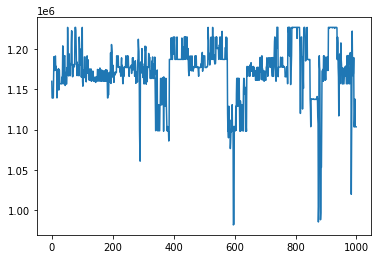

In [54]:
plt.plot(np.arange(0,1000), predictions_sum)

In [57]:
predictions[0,40]

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([499.64008, 393.31113, 499.29443, 391.07764, 497.85376, 467.2621 ,
       497.0074 , 546.8737 , 497.5136 , 555.29626, 498.095  , 556.13086,
       497.57492,   0.     , 496.9591 , 468.6987 , 495.56912,   0.     ,
       498.03033, 516.8565 , 498.37735,   0.     ,   0.     , 394.4756 ,
       499.26846,   0.     , 499.25897, 292.53564, 501.68973, 278.7328 ,
       501.2714 , 257.40393, 499.00772, 291.9477 , 497.54233, 303.69714,
       494.48853, 348.00888, 496.6417 , 364.3534 , 496.60992, 359.97226,
       498.6779 , 357.46896, 497.94403,   0.     , 486.7406 , 367.7068 ,
       499.89502, 291.69922, 499.36005, 304.19553, 499.27658, 350.0115 ,
       498.9949 , 354.28555, 501.09012, 355.42294, 499.81827, 345.67166,
       500.00015, 355.6395 , 487.54526, 348.5882 ], dtype=float32)>

In [59]:
sampled_dataY[0,40]

array([485.3502, 439.2325, 503.4748, 435.6133, 493.6432, 530.1279,
       508.2068, 624.7448, 479.209 , 626.8907, 466.192 , 622.8315,
       466.4923, 443.0063, 462.1733, 540.3649, 464.5618, 640.1575,
       445.6652, 635.116 , 437.1776, 630.0218, 485.3471, 439.2106,
       499.5153, 390.0015, 503.806 , 332.4882, 491.736 , 311.5186,
       497.3286, 288.2282, 503.806 , 332.4882, 482.3312, 348.664 ,
       443.6775, 399.6154, 397.1931, 413.2619, 397.1931, 413.2619,
       392.1533, 395.7729, 377.223 , 422.1048, 377.223 , 422.1048,
       503.806 , 332.4882, 519.8842, 348.6104, 509.5627, 393.0717,
       476.2727, 411.3513, 476.2727, 411.3513, 464.8629, 394.3017,
       461.6813, 423.342 , 461.6813, 423.342 ], dtype=float32)

In [58]:
predictions[0,20]

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([443.58624, 369.5602 , 442.23962, 367.2112 , 439.67337, 439.1234 ,
       439.26096, 513.185  , 439.73978, 519.701  , 440.11786, 521.55237,
       440.64777,   0.     , 438.39886, 440.63422, 438.5919 ,   0.     ,
       440.1264 , 473.18774, 441.13992,   0.     ,   0.     , 370.99512,
       442.1821 ,   0.     , 440.93433, 275.13818, 444.66776, 261.7531 ,
       444.07687, 241.81474, 441.33365, 274.4613 , 440.67145, 285.65732,
       437.76538, 326.78577, 439.63312, 341.17798, 439.83072, 333.09637,
       442.03882, 336.001  , 441.0297 ,   0.     , 436.82785, 344.29208,
       442.54062, 274.3468 , 441.92145, 286.24762, 440.9555 , 329.27298,
       440.2855 , 332.70413, 442.79596, 333.49255, 440.80023, 324.20325,
       441.44162, 333.43457, 436.45276, 322.73215], dtype=float32)>

In [55]:
predictions_sum

array([1160054.2 , 1139419.5 , 1139419.5 , 1139156.6 , 1139419.5 ,
       1139419.5 , 1169055.8 , 1190666.  , 1175398.5 , 1173626.1 ,
       1173626.1 , 1190746.9 , 1191585.5 , 1174099.8 , 1178801.2 ,
       1173499.9 , 1173986.  , 1139419.5 , 1173886.  , 1163687.2 ,
       1155465.2 , 1162337.9 , 1175908.  , 1149197.6 , 1173986.2 ,
       1174099.8 , 1157047.2 , 1157047.2 , 1157047.2 , 1157047.2 ,
       1157047.2 , 1157047.2 , 1157047.2 , 1165152.  , 1157047.2 ,
       1171234.  , 1204183.5 , 1200475.1 , 1174860.6 , 1157047.2 ,
       1157059.5 , 1191921.9 , 1191548.  , 1191921.9 , 1154890.8 ,
       1171015.9 , 1156491.4 , 1156489.6 , 1156603.8 , 1157047.2 ,
       1177176.5 , 1172458.4 , 1227210.5 , 1194433.4 , 1168862.  ,
       1166813.8 , 1194276.  , 1194272.2 , 1168856.5 , 1180656.4 ,
       1166873.  , 1182095.8 , 1180682.2 , 1180681.9 , 1208876.8 ,
       1223079.4 , 1221949.2 , 1169363.5 , 1165725.2 , 1166026.4 ,
       1166936.8 , 1180913.4 , 1180741.6 , 1180963.8 , 1178053

In [38]:
predictions[1,20]

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([530.94775, 425.6861 , 530.23944, 424.00946, 529.30835, 492.00867,
       528.04156, 575.09564, 528.47095, 585.08746, 528.69666, 584.4934 ,
       531.6108 , 427.43073, 531.9095 , 494.02744, 529.5448 , 577.68335,
       530.5533 , 585.51886, 531.1571 , 583.38934, 530.949  , 425.67795,
       531.71704, 374.9985 , 532.9671 ,   0.     , 533.7336 , 307.53113,
       533.91907, 285.0529 , 532.96826, 321.42844, 533.49445, 332.89484,
       533.4907 ,   0.     , 534.10645, 393.93924, 534.1124 , 393.94028,
       534.48303, 385.5388 , 534.5305 , 396.38873, 534.5232 , 396.38828,
       532.96906, 321.42596, 531.7403 , 333.57785, 529.7442 , 377.8631 ,
       529.9651 , 383.5723 , 529.9628 , 383.57132, 530.5732 , 375.54   ,
       530.1568 , 383.54843, 530.1601 , 383.54987], dtype=float32)>

In [27]:
evaluation = glocal_model_preprocessed.evaluate(sampled_dataX, sampled_dataY)

TypeError: ignored